# Infer ***nuclei*** - 1️⃣ 

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component #1: ***nuclei***  in order to understand interactome 

To measure shape, position, size, and interaction of eight organelles/cellular components ***nuclei***.  

Dependencies:
***Soma*** and ***cytosol*** inference rely on the ***nuclei*** inference.  Therefore all of the sub-cellular objects rely on the NU segmentation.


> CONVENTION:  "nuclei" for the segmentation of ALL nuclei in the image.  "nucleus" for the ***single*** soma-masked version.


## preamble

1. imports
2. setup
3. ~~choose_Z~~
4. get soma mask (if available)
5. infer-nuclei
    * input
    * pre-processing
    * core processing
    * post-processing
    * output
6. infer _nucleus_ : apply soma mask (if not available at #4)





### IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional, Union

import numpy as np

from aicssegmentation.core.pre_processing_utils import  image_smoothing_gaussian_slice_by_slice 
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                    export_inferred_organelle,
                                                                    list_image_files)

from infer_subc_2d.utils.img import *
from infer_subc_2d.organelles import fixed_get_optimal_Z_image, fixed_find_optimal_Z, find_optimal_Z

%load_ext autoreload
%autoreload 2



In [2]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )                       


## SETUP


CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.


In [3]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## infer ***nuclei***
 

## summary of steps

➡️ INPUT

- channel 0

PRE-PROCESSING
-  scale to min 0, max 1.0
- median Filter window 4
-  gaussian 1.34

CORE-PROCESSING
  - threshold method minimum cross-entropy.  
    - objects 50-400 pixels, 
    - threshold smoothing scale: 1.34 (later 1 pixel
    - threshold correction factor: 0.9 (later 1.2 )
    - lower / upper bounds  (.1,1) ?
    - log transformed thresholding
    - fill holes


POST-PROCESSING
  - fill holes
  - remove small objects


OUTPUT ➡️ 
- labels of NUCLEI


> #### Note:  in later steps we will limit each analysis to a single object, but at this stage we have multiple

NOTE:  using Allen Cell Segmenter  [Nucleophosmin](https://www.allencell.org/cell-observations/category/nucleophosmin) might be a good generic mechanism.  e.g.
-  [playground_npm1.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_npm1.ipynb) and [npm1.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_npm1.py) and [npm1_SR.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_npm1_SR.py)


> #### Note:  this initial inferred object -- the ***nuclei*** of the brightest cell -- is implicitly used in inferring the ***soma*** and ***cytosol*** objects.  


## INPUT prototype

Get the "raw" signals we need to analyze as well as any other dependencies in "inferred" objects.  

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.

In [5]:
###################
# INPUT
###################
raw_nuclei = select_channel_from_raw(img_data, NUC_CH)


## PRE-PROCESSING prototype


In [6]:
###################
# PRE_PROCESSING
###################           
# 
med_filter_size = 4   
gaussian_smoothing_sigma = 1.34
# nuclei = min_max_intensity_normalization(raw_nuclei )
# nuclei = median_filter_slice_by_slice( nuclei, size=med_filter_size  )
# nuclei = image_smoothing_gaussian_slice_by_slice(  nuclei, sigma=gaussian_smoothing_sigma)

nuclei =  scale_and_smooth(raw_nuclei,
                                                    median_sz = med_filter_size, 
                                                    gauss_sig = gaussian_smoothing_sigma)


> #### ASIDE: Thresholding
> [Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. In many cases, images can be adequately segmented by thresholding followed by labelling of *connected components*, which is a fancy way of saying "groups of pixels that touch each other".
> 
> Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. Below, we use Li. You can use `skimage.filters.threshold_<TAB>` to find different thresholding methods.

_Li_ procedure  better matches the CellProfiler pipeline which simply calls it "Minimum Cross Entropy" .


## CORE PROCESSING prototype

In [7]:
###################
# CORE_PROCESSING
###################

threshold_factor = 0.9 #from cellProfiler
thresh_min = .1
thresh_max = 1.
li_thresholded = apply_log_li_threshold(nuclei, thresh_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)


## POST PROCESSING prototype

> NOTE: the size parameters are by convention defined as one dimensional "width", so the inputs to the functions need to be _squared_ i.e. raised to the power of 2: `** 2`.   For volumetric (3D) analysis this would be _cubed_:`**3`

In [8]:
###################
# POST_PROCESSING
###################

hole_width = 25  
# # wrapper to remoce_small_objects
#removed_holes = remove_small_holes(li_thresholded, hole_width ** 2 )
removed_holes = hole_filling_linear_size(li_thresholded, hole_min=0, hole_max=hole_width)

small_object_width = 15
cleaned_img = size_filter_linear_size(removed_holes, # wrapper to remove_small_objects which can do slice by slice
                                                                min_size= small_object_width)

cleaned_img2 = fill_and_filter_linear_size(li_thresholded, hole_min=0, hole_max=hole_width, min_size= small_object_width)

In [9]:
nuclei_object = cleaned_img
NU_labels = label( cleaned_img )
NU_signal = raw_nuclei


## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:
viewer = napari.Viewer()


In [11]:

viewer.add_image(
    nuclei_object,
    opacity=0.3,
)    


viewer.add_labels(
    NU_labels,
    opacity=0.3,
)



<Labels layer 'NU_labels' at 0x14101a4c0>

## SAVE inferred nuclei to .tif file

Based on the _prototyping_ above define the function to infer nuclei.  


In [15]:


out_file_n = export_inferred_organelle(nuclei_object, "nuclei", meta_dict, out_data_path)


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


saved file: /Users/ahenrie/Projects/Imaging/data/out/nuclei_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff


## DEFINE `_infer_nuclei` function

Based on the _prototyping_ above define the function to infer nuclei.  


In [12]:
##########################
#  _infer_nuclei
##########################
def _infer_nuclei( in_img: np.ndarray, 
                            nuc_ch: Union[int,None],
                            median_sz: int, 
                            gauss_sig: float,
                            thresh_factor: float,
                            thresh_min: float,
                            thresh_max: float,
                            max_hole_w: int,
                            small_obj_w: int
                        ) -> np.ndarray:
    """
    Procedure to infer nuclei from linearly unmixed input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    median_sz: int
        width of median filter for signal
    gauss_sig: float
        sigma for gaussian smoothing of  signal
    thresh_factor: float
        adjustment factor for log Li threholding
    thresh_min: float
        abs min threhold for log Li threholding
    thresh_max: float
        abs max threhold for log Li threholding
    max_hole_w: int
        hole filling cutoff for nuclei post-processing
    small_obj_w: int
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """

    ###################
    # PRE_PROCESSING
    ###################                
    if nuc_ch is None:
        nuc_ch = NUC_CH

    nuclei = select_channel_from_raw(in_img, nuc_ch)

    nuclei =  scale_and_smooth(nuclei,
                        median_sz = median_sz, 
                        gauss_sig = gauss_sig)

    ###################
    # CORE_PROCESSING
    ###################
    nuclei_object = apply_log_li_threshold(nuclei, 
                                                                    thresh_factor=thresh_factor, 
                                                                    thresh_min=thresh_min, 
                                                                    thresh_max=thresh_max)

    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = fill_and_filter_linear_size(nuclei_object, hole_min=0, hole_max=max_hole_w, min_size= small_obj_w)
    return nuclei_object


[autoreload of infer_subc_2d.organelles.nuclei failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/napariNEW/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles/nuclei.py", line 12
 

## DEFINE `_fixed_infer_nuclei` function


In [13]:
##########################
#  fixed_infer_nuclei
##########################
def _fixed_infer_nuclei(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer soma from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
 
    Returns
    -------------
    nuclei_object
        inferred nuclei
    
    """
    nuc_ch = NUC_CH
    median_sz = 4   
    gauss_sig = 1.34
    threshold_factor = 0.9
    thresh_min = 0.1
    thresh_max = 1.0
    max_hole_w = 25
    small_obj_w = 15

    return _infer_nuclei( in_img,
                                    nuc_ch,
                                    median_sz,
                                    gauss_sig,
                                    threshold_factor,
                                    thresh_min,
                                    thresh_max,
                                    max_hole_w,
                                    small_obj_w  )


---------------------
## TEST `_infer_nuclei`  function defined above


In [15]:

_NU_object =  _fixed_infer_nuclei(img_data) 


---------------------
# TEST `infer_nuclei` exported functions

> the prototype `_infer_nuclei` was copied to the [`.organelles.nuclei`](../infer_subc_2d/organelles/nuclei.py) sub-module 
##
`infer_nuclei` procedure

Use the `infer_nuclei` function to infer the Nucleus and export it as an _ome.tif_ for easy reference.

In [16]:
from infer_subc_2d.organelles.nuclei import infer_nuclei, fixed_infer_nuclei

nuclei_object =  fixed_infer_nuclei(img_data) 


## Visualize  2


In [20]:
viewer.add_image(
    _NU_object,
    opacity=0.3,
)    


viewer.add_labels(
    label(_NU_object),
    opacity=0.3,
)


<Labels layer 'Labels' at 0x16dfd0190>

In [21]:
viewer.add_image(
    nuclei_object,
    opacity=0.3,
)    


<Image layer 'nuclei_object [1]' at 0x1710efa00>

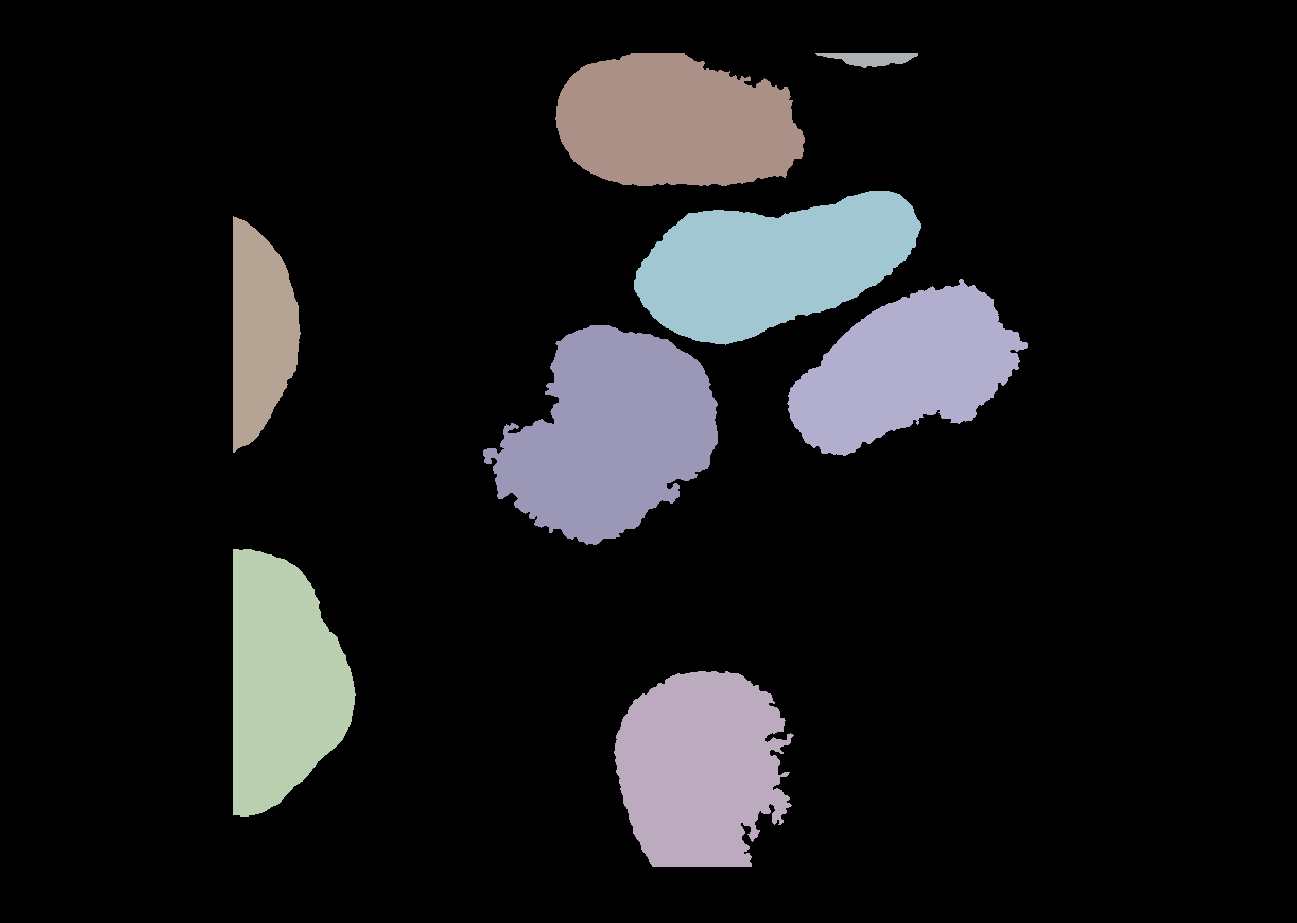

In [22]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


In [24]:
viewer.close()

In [ ]:
# copy to utils.img
def _scale_and_smooth(img_in: np.ndarray,
                       median_sz: int = 1, 
                       gauss_sig: float = 1.34,
                       slice_by_slice: bool=True
                ) -> np.ndarray:
    """
    helper to perform min-max scaling, and median+gaussian smoothign all at once
    Parameters
    ------------
    img_in: np.ndarray
        a 3d image
    median_sz: int
        width of median filter for signal
    gauss_sig: float
        sigma for gaussian smoothing of  signal
    slice_by_slice: 
        NOT IMPLIMENTED.  toggles whether to do 3D operations or slice by slice in Z

    Returns
    -------------
        np.ndimage 

    """
    img  = min_max_intensity_normalization(img_in.copy()) # is this copy nescesa

    # TODO:  make non-slice-by-slice work
    slice_by_slice = True  
    if slice_by_slice:
        if median_sz > 1:
            img = median_filter_slice_by_slice(img, size=median_sz)
        img = image_smoothing_gaussian_slice_by_slice( img, sigma=gauss_sig)
    else: 
        print(" PLEASE CHOOOSE 'slice-by-slice', 3D is not yet implimented")
 
    return img



In [ ]:
# copy to utils.img
def _get_interior_labels(img_in: np.ndarray)  -> np.ndarray:
    """
    gets the labeled objects from the X,Y "interior" of the image. We only want to clear the objects touching the sides of the volume, but not the top and bottom, so we pad and crop the volume along the 0th axis to avoid clearing the mitotic nucleus

    Parameters
    ------------
    img_in: np.ndarray
        a 3d image

    Returns
    -------------
        np.ndimage of labeled segmentations NOT touching the sides

    """
    segmented_padded = np.pad(
        label(img_in),
        ((1, 1), (0, 0), (0, 0)),
        mode='constant',
        constant_values=0,
    )
    interior_labels = clear_border(segmented_padded)[1:-1]
    return interior_labels




In [ ]:
def fill_and_filter_linear_size(
    img: np.ndarray, hole_min: int, hole_max: int, min_size: int, method: str = "slice_by_slice", connectivity: int = 1
) -> np.ndarray:
    """wraper to aiscsegmentation `hole_filling` and `size_filter` with size argument in linear units

    Parameters
    ------------
    img:
        the image to filter on
    hole_min: int
        the minimum width of the holes to be filled
    hole_max: int
        the maximum width of the holes to be filled
    min_size: int
        the minimum size expressed as 1D length (so squared for slice-by-slice, cubed for 3D)
    method: str
        either "3D" or "slice_by_slice", default is "slice_by_slice"
    connnectivity: int
        the connectivity to use when computing object size
    Returns
    -------------
        a binary image after hole filling and filtering small objects; np.ndarray
    """
    if not img.any():
        return img
    img = hole_filling(img, hole_min=hole_min**2, hole_max=hole_max**2, fill_2d=True)
    if method == "3D":
        return size_filter(img, min_size=min_size**3, method="3D", connectivity=connectivity)
    elif method == "slice_by_slice":
        return size_filter(img, min_size=min_size**2, method="slice_by_slice", connectivity=connectivity)



-------------
## SUMMARY

The above details how the nuclei object is inferred.  

### NEXT: INFER CYTOSOL

proceed to [03_infer_cytosol.ipynb](./03_infer_cytosol.ipynb)
